In [55]:
from pathlib import Path
import json
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import keras_tuner as kt
import tensorflow as tf

import hyper_model_creator

In [53]:
trials_dir = Path('trials', 'hyperband_resnet')
hypermodel = hyper_model_creator.BuildHyperModel()

tuner = kt.Hyperband(
    hypermodel,
    objective=kt.Objective('val_weightedf2score', direction='max'),
    directory=trials_dir.parent,
    project_name=trials_dir.name,
)
# tuner.search_space_summary()
tuner.results_summary(num_trials=5)

Reloading Tuner from trials/hyperband_resnet/tuner0.json
Results summary
Results in trials/hyperband_resnet
Showing 5 best trials
Objective(name="val_weightedf2score", direction="max")

Trial 0140 summary
Hyperparameters:
class_weight: True
training_years: 2017_2018_2019
kernel_regularizer: l1l2
spatial_dropout: 0.5
activation: leaky_relu
pool_size: 4
dropout: 0.1
bias_initializer: False
learning_rate: 0.01
loss_function: binary_crossentropy
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0131
Score: 0.6896040439605713

Trial 0143 summary
Hyperparameters:
class_weight: True
training_years: 2017_2018_2019
kernel_regularizer: l1l2
spatial_dropout: 0.5
activation: leaky_relu
pool_size: 4
dropout: 0.1
bias_initializer: False
learning_rate: 0.01
loss_function: binary_crossentropy
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0140
Score: 0.6886311769485474

Trial 0226 summary
Hyperparameters:
class_weight: T

In [2]:
rows = []
for trial in sorted(list(trials_dir.glob('trial_*'))):
    with open(trial.joinpath('trial.json')) as f:
        results = json.load(f)
        row = {'score': results['score']} | results['hyperparameters']['values']
        rows.append(row)

trials_df = pd.DataFrame(rows).sort_values(by='score', ascending=False)
trials_df = trials_df[[c for c in trials_df.columns if 'tuner' not in c]]

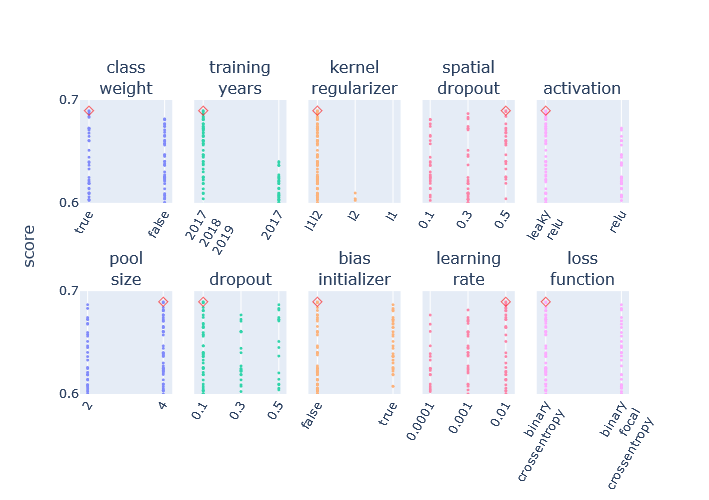

In [45]:
nrows, ncols = 2, 5
fig = make_subplots(
    rows=nrows, cols=ncols, shared_yaxes='all', y_title='score',
    subplot_titles=trials_df.columns[1:].str.replace('_', '<br>'),
    vertical_spacing=0.3,
)

for i, col in enumerate(trials_df.columns[1:]):
    if trials_df[col].dtype == object:
        x = trials_df[col].str.replace('_', '<br>')
    else:
        x = trials_df[col]

    position = dict(row=(i//ncols)+1, col=(i%ncols)+1)
    fig.append_trace(go.Scatter(
        y=trials_df['score'],
        x=x,
        mode='markers',
        marker_size=3,
        opacity=0.8,
    ), **position)
    
    fig.append_trace(go.Scatter(
        y=[trials_df['score'].max()],
        x=[x[trials_df['score'].idxmax()]],
        mode='markers',
        marker_symbol='diamond-open',
        marker_color='red',
        marker_size=7,
        opacity=0.6,
    ), **position)

    fig.update_xaxes(
        type='log' if 'learning_rate' in col else None,
        tickformat='.1r',
        tickangle=-60,
        tickvals=x.unique(),
        **position
    )
    fig.update_yaxes(range=[0.6, 0.7], tickvals=[0.6, 0.7])

fig.update_layout(
    height=500, width=700, showlegend=False,
    margin=dict(l=80, r=80, t=100, b=80)
)
fig.write_image(Path('report', 'figures', 'figures_tuner', 'fixed_layers.pdf'))
fig.show()

AttributeError: 'Hyperband' object has no attribute 'built'